# HPC Mini-Challenge 2 - Beschleunigung in Data Science
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

### Ressourcen
* HPC mit Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (z.B. GPU Ressourcen)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - Siehe auch aktuelles Tutorial von 2021

Abgabe von: <font color='lightblue'>Etienne Roulet</font>


## Ausgangslage/Problemstellung


Das menschliche Gehirn verliert mit zunehmendem Alter an Funktion. Ein Teil davon ist "gesundes Altern", d.h. es passiert bei jedem Menschen. Ein relativ großer Prozentsatz der alternden Bevölkerung erlebt jedoch auch einen kognitiven Rückgang, der extremer ist als bei anderen. Eine mildere Version davon wird als 'leichte kognitive Beeinträchtigung' (MCI) bezeichnet, bei der die Person grösstenteils noch funktionieren kann. Bei einem Teil der MCI-Patienten schreitet die Krankheit fort und führt zu Demenz bzw. Alzheimer. In diesem Projekt liegen uns MRI-Bilder des Gehirns von Alzheimerpatienten vor. Im spezifischen analysieren wir die Entwicklung von Alzheimer-Patienten anhand von MRI-Bildern, welche über eine bestimmte Zeit zur Verfügung stehen. Es stellt sich die Frage, wie gut sich die Veränderungen des Krankheitsbildes mittels Korrelationen über die Bildanalyse zeigen lassen. Zur Analyse sind Gigabytes von Daten in Form von 3D Gehirn-Scans vorhanden. Die Verarbeitung dieser grossen Datenmengen kann von Komprimierung profitieren.

Das Verständnis von Gedächtnis- und Kognitionsstörungen und die Möglichkeit, den Gesundheitszustand des Gehirns zu erkennen, vorherzusagen und zu überwachen, ist ein gesellschaftlich und wirtschaftlich relevantes Thema der angewandten Wissenschaft. Alle neuen Erkenntnisse, die datenwissenschaftliche Methoden liefern können, werden zur Entwicklung von Lösungen beitragen, mit denen die Gesundheit des Gehirns erkannt, vorhergesagt und überwacht werden kann.

### Daten
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) ist ein internationales Projekt zur Erfassung von Daten über die Alzheimer-Krankheit und andere verwandte Gehirnerkrankungen, die zu einem kognitiven Abbau führen. Die Initiative wurde mit grossem Enthusiasmus aufgenommen, und viele Mitarbeiter aus der ganzen Welt haben Daten zur Verfügung gestellt, die sie in ihren eigenen Forschungsteams gesammelt haben. Die ADNI-Initiative ist ein öffentliches (gemeinnütziges) Projekt, da viele Forschungseinrichtungen auf der ganzen Welt mit Steuergeldern dazu beigetragen haben. Das bedeutet zwei Dinge: Die Daten stehen uns zwar für Forschungs- und Bildungszwecke zur Verfügung, aber wir dürfen die Daten **nicht** an andere weitergeben oder kommerzialisieren.



***Wichtig!*** Die Studierenden dürfen die Daten nur für Forschungszwecke verwenden und erhalten nur einen Beispielsdatensatz. Die ADNI-Daten dürfen nur lokal auf dem Computer oder auf FHNW-Ressourcen wie dem GitLab-Repository, d.h. nicht auf Github, gespeichert werden. Siehe [ADNI Datennutzungsvereinbarung](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="images/mri-example.png" alt="MRI example image (coronal slice)" width="150"/> <img src="images/slicing.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

## Zielsetzung

In dieser Aufgabe sollen die Parallelisierung und Beschleunigung unterschiedlicher Methoden von Bildrekonstruktion basierend auf komprimierten (zerlegten) Daten implementiert, analyisiert und diskutiert werden. Die Rekonstruktion der Daten aus der komprimierten Version soll dabei möglichst in Echtzeit geschehen. 

## Lösungsweg / Vorgehen

Wir lösen diese Aufgabenstellung indem wir die Singulärwertzerlegung (SVD: singular value decomposition) als Kompressionsmethode verwenden (Matrixfaktorisierung). Siehe Abbildungen unten. Um die Rekonstruktion der Daten aus der SVD-Matrixfaktoriseriung möglichst in Echtzeit zu bewerkstelligen, evaluieren wir dafür verschiedene Methoden der Parallelisierung und Beschleunigung in Python. 
* Beschleunigungsvarianten auf der CPU:
    - Numpy Operationen inkl. Broadcasting
    - Numba
    - Threads
* Beschleunigung auf der GPU:
    - Cupy (analog zu Numpy)
    - Numba (analog zu Numba)

<img src="images/svd_reco.png" alt="svd vis" width="300"/> <img src="images/svd.png" alt="svd" width="300"/>

## Daten Zerlegen
### 1.1 Daten laden


In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import imageio.v3 as imageio
import numpy as np
import glob

subfolder = "001"
folders = os.path.join("adni_png", subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Get all the names of the files
names = [f[-17:-4] for f in files]

print(images.shape)

(7, 256, 170)


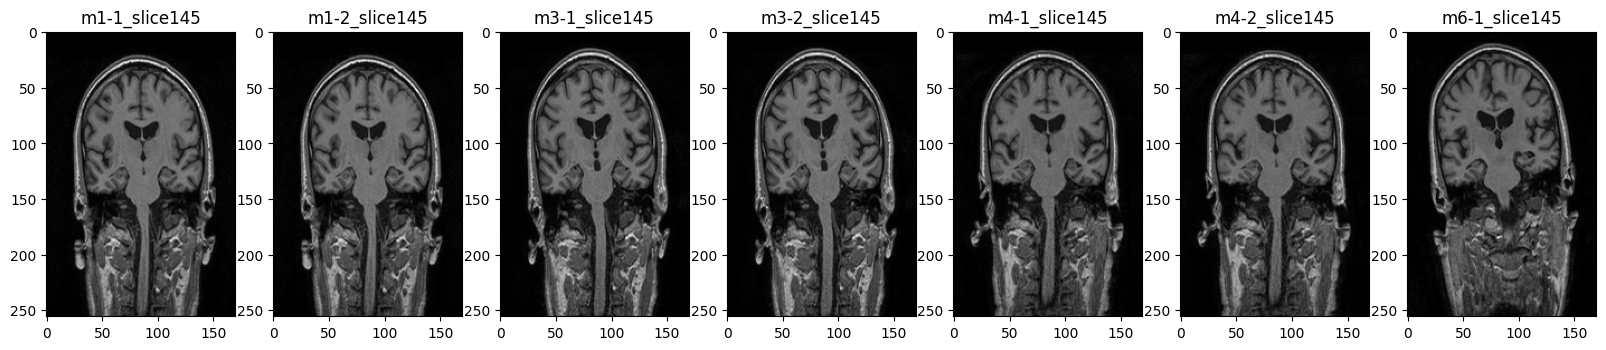

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(20, 10))

for a in range(images.shape[0]):
    ax = fig.add_subplot(1, images.shape[0], a + 1)
    ax.imshow(images[a], cmap="gray")
    ax.set_title(names[a])

### 1.2 Daten zerlegen

In [4]:
def reconstruct_svd(u, s, vt, k):
    """SVD reconstruction for k components using np.dot()

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[..., :k], np.dot(np.diag(s[:k]), vt[:k, ...]))

    return reco

In [5]:
from skimage import metrics


# calculate various metrics for the reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"

original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


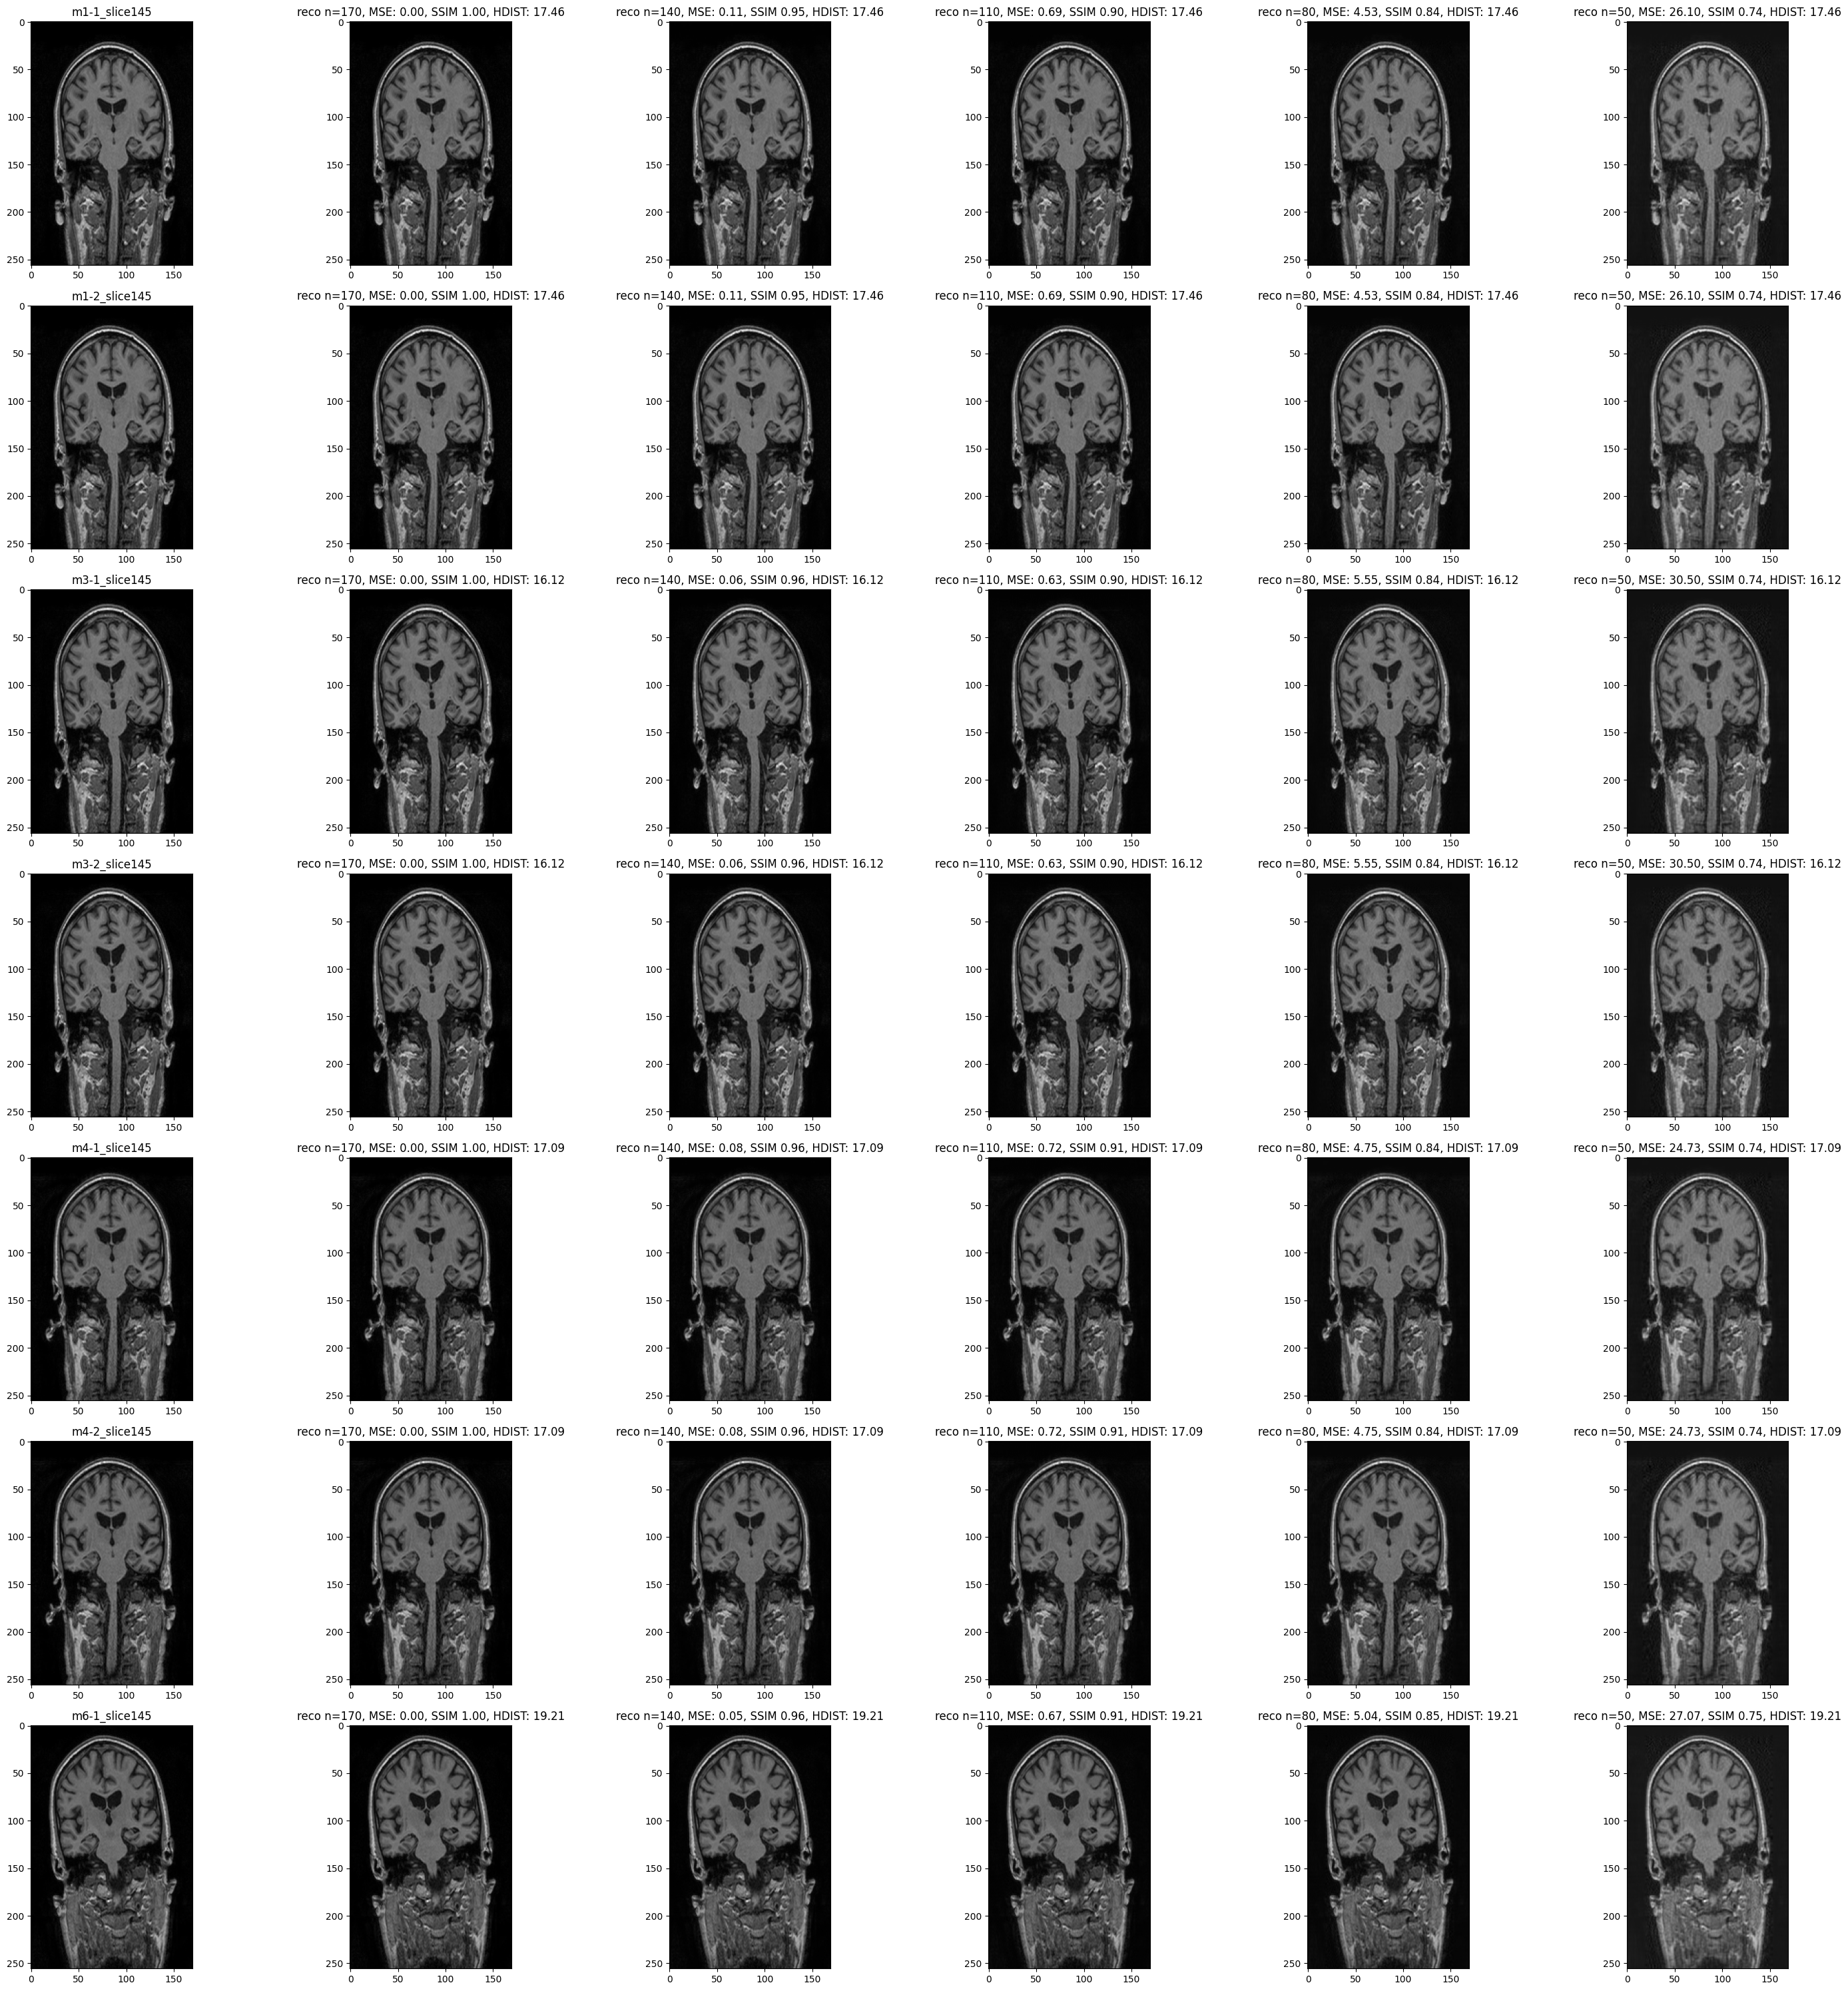

In [6]:
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30, 30))

for a in range(images.shape[0]):
    im = images[a]
    im = im - im.min() / im.max() - im.min()  # normalize image
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    axs[a, 0].imshow(im, cmap="gray")
    axs[a, 0].set_title(names[a])

    if a == 0:
        print("original size: ", im.shape[0] * im.shape[1])

    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd(u, s, vt, n)
        if a == 0:
            print(
                "decomposed to n = ",
                n,
                ", size: ",
                u.shape[0] * n + n + vt.shape[0] * n,
            )

        axs[a, idx + 1].imshow(reco, cmap="gray")
        axs[a, idx + 1].set_title(
            "reco n=" + str(n) + ", " + calculate_metrics(im, reco)
        )
plt.tight_layout()

### 2 Rekonstruktionsvarianten
Siehe Bilder in der Einführung (Teil: Vorgehen).

In [7]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(reco, cmap="gray")
    ax.set_title("reco with " + str(k) + " components")

#### 2.1 For-Loops
Rekonstruiere nun die zerlegte SVD Matrix mittels For-Loops gemäss Formel B.4 (oben). Rekonstruiere nur die ersten $k$ Komponenten der SVD-Matrixfaktorisierung $U, S, V^T$, wobei $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, und  $V^T \in \mathbb{R}^{NxN}$. 

Implementiere dafür folgende drei Funktionen - jeweils mit 3, 2 bzw. 1 For-Loop:

In [8]:
def reconstruct_svd_for_loops3(u, s, vt, k):
    """SVD reconstruction for k components using 3 for-loops

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape
    reco = np.zeros((m, n))

    for i in range(m):
        for j in range(n):
            for l in range(k):
                reco[i, j] += s[l] * u[i, l] * vt[l, j]

    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops2(u, s, vt, k):
    """SVD reconstruction for k components using 2 for-loops

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape
    reco = np.zeros((m, n))

    for i in range(m):
        for l in range(k):
            reco[i, :] += s[l] * u[i, l] * vt[l, :]
    ### END SOLUTION

    return reco

In [10]:
def reconstruct_svd_for_loops1(u, s, vt, k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    m, n = u.shape
    reco = np.zeros((m, n))

    for l in range(k):
        reco += s[l] * np.outer(u[:, l], vt[l, :])

    return reco

#### 2.2 Einstein Summation
Implementiere nun eine möglichst schnelle Rekonstruktionsvariante mittels `np.einsum()` gemäss folgender Funktion:

In [11]:
def reconstruct_svd_einsum1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = np.einsum("ik,k,kl->il", u[:, :k], s[:k], vt[:k, :])
    ### END SOLUTION

    return reco

#### 2.3 Broadcasting
Implementiere nun zwei Rekonstruktionsvarianten mittels Broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc

In [12]:
def reconstruct_svd_broadcast1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 1

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:, :k] * s[:k] @ vt[:k, :]
    ### END SOLUTION

    return reco

In [13]:
def reconstruct_svd_broadcast2(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 2

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:, :k] @ (s[:k].reshape((-1, 1)) * vt[:k, :])
    ### END SOLUTION

    return reco

#### 2.4 Vergleich der Resultate
Vergleiche die Resultate der Implementierungen anhand eines Beispielbildes. Sind die Rekonstruktionen nahezu gleich? Wie sieht es mit der Rekonstruktionsgeschwindigkeit aus - abhängig von der Anzahl rekonstruierter Komponenten?

Number of Components: 100%|██████████| 91/91 [02:34<00:00,  1.69s/it]


Model  Number of Components  Time Taken
0               reconstruct_svd                    10    0.000448
1    reconstruct_svd_for_loops3                    10    0.295888
2    reconstruct_svd_for_loops2                    10    0.007832
3    reconstruct_svd_for_loops1                    10    0.000887
4       reconstruct_svd_einsum1                    10    0.000339
..                          ...                   ...         ...
632  reconstruct_svd_for_loops2                   100    0.073477
633  reconstruct_svd_for_loops1                   100    0.004887
634     reconstruct_svd_einsum1                   100    0.002857
635  reconstruct_svd_broadcast1                   100    0.000326
636  reconstruct_svd_broadcast2                   100    0.000334

[637 rows x 3 columns]

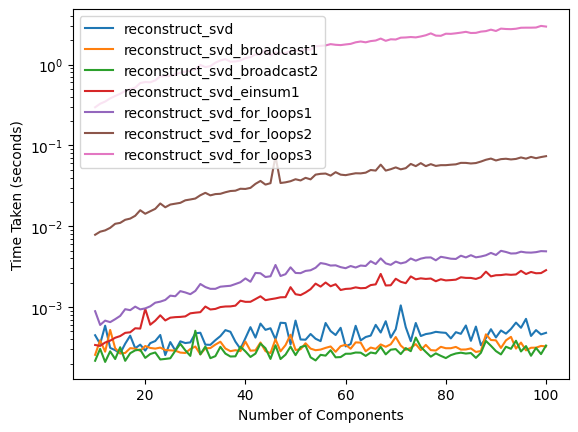

In [14]:
### BEGIN SOLUTION
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
from tqdm import tqdm


def perform_reconstruction(model, u, s, vt, num_components):
    start = timeit.default_timer()
    model(u, s, vt, num_components)
    end = timeit.default_timer()
    return end - start


models = [
    reconstruct_svd,
    reconstruct_svd_for_loops3,
    reconstruct_svd_for_loops2,
    reconstruct_svd_for_loops1,
    reconstruct_svd_einsum1,
    reconstruct_svd_broadcast1,
    reconstruct_svd_broadcast2,
]

model_names = [
    "reconstruct_svd",
    "reconstruct_svd_for_loops3",
    "reconstruct_svd_for_loops2",
    "reconstruct_svd_for_loops1",
    "reconstruct_svd_einsum1",
    "reconstruct_svd_broadcast1",
    "reconstruct_svd_broadcast2",
]

# Initialize DataFrame
df = pd.DataFrame(columns=["Model", "Number of Components", "Time Taken"], dtype=object)


for num_components in tqdm(range(10, 101), desc="Number of Components"):
    for model, name in zip(models, model_names):
        time_taken = perform_reconstruction(model, u, s, vt, num_components)
        df.loc[len(df)] = [name, num_components, time_taken]

# Display DataFrame
display(df)

for name, time_list in df.groupby("Model")["Time Taken"]:
    plt.plot(range(10, 101), time_list, label=name)

plt.xlabel("Number of Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()
### END SOLUTION

In [15]:
### BEGIN SOLUTION
# Check if the results are the same
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_for_loops3, u, s, vt, 20),
    rtol=1,
)
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_for_loops2, u, s, vt, 20),
    rtol=1,
)
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_for_loops1, u, s, vt, 20),
    rtol=10,
)
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_einsum1, u, s, vt, 20),
    rtol=10,
)
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_broadcast1, u, s, vt, 20),
    rtol=30,
)
assert np.allclose(
    perform_reconstruction(reconstruct_svd, u, s, vt, 20),
    perform_reconstruction(reconstruct_svd_broadcast2, u, s, vt, 20),
    rtol=30,
)
### END SOLUTION

#### 2.5 Interpretation der Resultate

Welche der Implementierungen war am schnellsten? Was waren deine Beobachtungen während  der Implementierung? Wo können solche Optimierungen sonst noch eingesetzt werden? Diskutiere in ca. 150-200 Wörtern.

<font color='lightblue'>
Der Plot zeigt die Zeit (in Sekunden) auf der y-Achse und die Anzahl der Komponenten auf der x-Achse für verschiedene Methoden zur Rekonstruktion von SVD (Singulärwertzerlegung). Die dargestellten Methoden sind:

- reconstruct_svd (blaue Linie)
- reconstruct_svd_broadcast1 (orange Linie)
- reconstruct_svd_broadcast2 (grüne Linie)
- reconstruct_svd_einsum1 (rote Linie)
- reconstruct_svd_for_loops1 (lila Linie)
- reconstruct_svd_for_loops2 (braune Linie)
- reconstruct_svd_for_loops3 (rosa Linie)

Die y-Achse ist logarithmisch skaliert, was eine breite Palette von Zeitwerten sichtbar macht.

### Interpretation:

Die schnellste Methode über alle getesteten Komponenten hinweg ist "reconstruct_svd_broadcast1" (orange Linie), gefolgt von "reconstruct_svd_broadcast2" (grüne Linie). Diese Methoden zeigen konsistent niedrige Zeitwerte, unabhängig von der Anzahl der Komponenten. Die "reconstruct_svd" Methode (blaue Linie) ist ebenfalls schnell und stabil. Im Gegensatz dazu sind die Methoden "reconstruct_svd_for_loops" (lila, braune, und rosa Linien) deutlich langsamer, wobei "reconstruct_svd_for_loops3" die langsamste ist. Was auch Sinn macht, denn jeder weiss wär in Python Nested Loops baut, baut sich ein Sanduhranzeige Programm.

Die besten Methoden hinsichtlich der Ausführungszeit und Stabilität sind somit "reconstruct_svd_broadcast1" und "reconstruct_svd_broadcast2". Diese Methoden sollten bevorzugt werden, da sie unabhängig von der Anzahl der Komponenten die niedrigsten und konstantesten Laufzeiten aufweisen. Die normale SVD methode könnte Numerisch Instabil sein, bei grossen Inputdaten.

Meine Internetrecherche brachte folgendes:

- SVD: Geeignet für kleine Systeme, die schnelle Rekonstruktionszeiten erfordern.
- Broadcast-Varianten von SVD: Empfehlenswert für große Systeme mit mehreren CPUs/GPUs, um die Rekonstruktionszeit zu verkürzen.
- For-Schleifen-Varianten: Optimale Wahl für sehr große Systeme, die numerische Stabilität erfordern.
- Einsum-Funktion: Kann aufgrund ihrer einfachen Implementierung eine Option für kleine bis mittlere Systeme sein, kann aber bei größeren Systemen langsamer sein.

</font>

### 3 Parallelisierung mittels Numba

Implementiere nun eine möglichst schnelle Rekonstruktionsvariante des SVDs mittels Numba. Ist es möglich, den Code mit Numba zu beschleunigen? Führe dazu eine Diagnostik aus. Wenn ja, was ist der Speedup-Faktor und welche(r) Teil(e) konnte(n) parallelisiert werden? Falls nein, was sind die Gründe, weshalb es sich nicht parallelisieren lässt? Lassen sich verschachtelte Schleifen parallelisieren? Warum? Diskutiere in ca. 150-200 Wörtern, wann und warum sich Numba für die Parallelisierung eignet - anhand deines Beispiels.

Beachte:
* Beim ersten Mal Ausführen des Codes wird die Zeit des Kompilierens mit eingerechnet.
* Numba eignet sich gut für For-Schleifen

In [16]:
import numba
from numba import prange
from numba import njit


### BEGIN SOLUTION
@njit
def reconstruct_svd_numba_without_loops(u, s, vt, k):
    """SVD reconstruction for k components using Numba

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    u = np.ascontiguousarray(u)
    s = np.ascontiguousarray(s)
    vt = np.ascontiguousarray(vt)

    reco = np.dot(u[..., :k], np.dot(np.diag(s[:k]), vt[:k, ...]))

    return reco


### END SOLUTION
@numba.jit(parallel=True, nopython=True)
def reconstruct_svd_numba(u, s, vt, k):
    """SVD reconstruction for k components using numba

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]

    # Reconstruct matrix A_k using U_k, S_k, and V_k^T
    reco = np.zeros((m, n), dtype=u.dtype)

    for i in prange(m):
        for j in prange(n):
            sum = 0.0
            for l in range(k):
                sum += u_k[i, l] * s_k[l] * vt_k[l, j]
            reco[i, j] = sum

    return reco


@numba.jit(parallel=True, nopython=True, fastmath=True, cache=True)
def reconstruct_svd_numba_optimized(u, s, vt, k):
    u = np.ascontiguousarray(u)
    s = np.ascontiguousarray(s)
    vt = np.ascontiguousarray(vt)

    m, n = u.shape[0], vt.shape[1]
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]

    reco = np.zeros((m, n), dtype=u.dtype)

    for i in numba.prange(m):
        for j in numba.prange(n):
            sum = 0.0
            for l in numba.prange(k):
                sum += u_k[i, l] * s_k[l] * vt_k[l, j]
            reco[i, j] = sum

    return reco

    ### END SOLUTION

In [17]:
### BEGIN SOLUTION
k = 20


def time_execution(func, *args):
    """Times the execution of a function.

    Inputs:
    func: function to time
    *args: arguments to pass to the function

    Output:
    execution time in seconds
    """
    start_time = timeit.default_timer()
    func(*args)
    end_time = timeit.default_timer()

    return end_time - start_time


# Timing the Numba-optimized function
execution_time = time_execution(reconstruct_svd_numba, u, s, vt, k)
print(f"Numba with compile time for k={k}: {execution_time:.4f} seconds")

execution_time = time_execution(reconstruct_svd_numba, u, s, vt, k)
print(f"Numba execute time for k={k}: {execution_time:.4f} seconds")

execution_time = time_execution(reconstruct_svd_numba_without_loops, u, s, vt, k)
print(f"Numba execute without loops time for k={k}: {execution_time:.4f} seconds")

execution_time = time_execution(reconstruct_svd_numba_without_loops, u, s, vt, k)
print(
    f"Numba with compile time without loops time for k={k}: {execution_time:.4f} seconds"
)

execution_time = time_execution(reconstruct_svd_numba_optimized, u, s, vt, k)
print(f"Numba optimized with compile time for k={k}: {execution_time:.4f} seconds")

execution_time = time_execution(reconstruct_svd_numba_optimized, u, s, vt, k)
print(f"Numba optimized execute time for k={k}: {execution_time:.4f} seconds")


### END SOLUTION

Numba with compile time for k=20: 1.2938 seconds
Numba execute time for k=20: 0.0005 seconds


C:\Users\super\AppData\Local\Temp\ipykernel_15136\3950868085.py:24: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  reco = np.dot(u[..., :k], np.dot(np.diag(s[:k]), vt[:k, ...]))


Numba execute without loops time for k=20: 1.0426 seconds
Numba with compile time without loops time for k=20: 0.0004 seconds
Numba optimized with compile time for k=20: 0.9932 seconds
Numba optimized execute time for k=20: 0.0005 seconds


Number of Components: 100%|██████████| 91/91 [02:39<00:00,  1.75s/it]


Model  Number of Components  Time Taken
0                        reconstruct_svd                    10    0.000479
1             reconstruct_svd_for_loops3                    10    0.320665
2             reconstruct_svd_for_loops2                    10    0.007455
3             reconstruct_svd_for_loops1                    10    0.000809
4                reconstruct_svd_einsum1                    10    0.000311
..                                   ...                   ...         ...
905           reconstruct_svd_broadcast1                   100    0.000319
906           reconstruct_svd_broadcast2                   100    0.000261
907  reconstruct_svd_numba_without_loops                   100    0.000700
908                reconstruct_svd_numba                   100    0.000496
909      reconstruct_svd_numba_optimized                   100    0.000355

[910 rows x 3 columns]

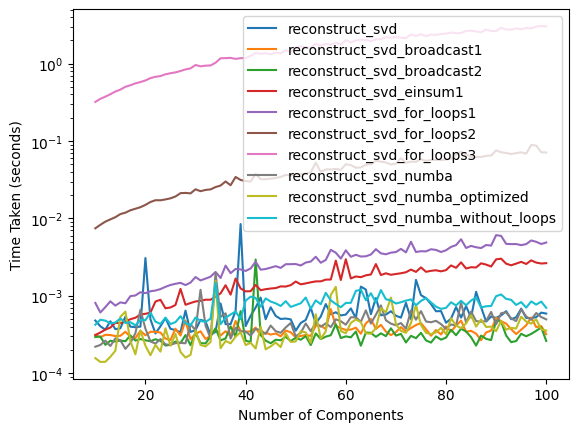

In [18]:
models = [
    reconstruct_svd,
    reconstruct_svd_for_loops3,
    reconstruct_svd_for_loops2,
    reconstruct_svd_for_loops1,
    reconstruct_svd_einsum1,
    reconstruct_svd_broadcast1,
    reconstruct_svd_broadcast2,
    reconstruct_svd_numba_without_loops,
    reconstruct_svd_numba,
    reconstruct_svd_numba_optimized,
]

model_names = [
    "reconstruct_svd",
    "reconstruct_svd_for_loops3",
    "reconstruct_svd_for_loops2",
    "reconstruct_svd_for_loops1",
    "reconstruct_svd_einsum1",
    "reconstruct_svd_broadcast1",
    "reconstruct_svd_broadcast2",
    "reconstruct_svd_numba_without_loops",
    "reconstruct_svd_numba",
    "reconstruct_svd_numba_optimized",
]

# Initialize DataFrame
df = pd.DataFrame(columns=["Model", "Number of Components", "Time Taken"], dtype=object)

for num_components in tqdm(range(10, 101), desc="Number of Components"):
    for model, name in zip(models, model_names):
        time_taken = perform_reconstruction(model, u, s, vt, num_components)
        df.loc[len(df)] = [name, num_components, time_taken]

# Display DataFrame
display(df)

for name, time_list in df.groupby("Model")["Time Taken"]:
    plt.plot(range(10, 101), time_list, label=name)


plt.xlabel("Number of Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()

<font color='lightblue'>

Der Plot zeigt die Zeit (in Sekunden) auf der y-Achse und die Anzahl der Komponenten auf der x-Achse für verschiedene Methoden zur Rekonstruktion von SVD (Singulärwertzerlegung). Neue Methoden unter Verwendung von Numba wurden hinzugefügt:

- reconstruct_svd (blaue Linie)
- reconstruct_svd_broadcast1 (orange Linie)
- reconstruct_svd_broadcast2 (grüne Linie)
- reconstruct_svd_einsum1 (rote Linie)
- reconstruct_svd_for_loops1 (lila Linie)
- reconstruct_svd_for_loops2 (braune Linie)
- reconstruct_svd_for_loops3 (rosa Linie)
- reconstruct_svd_numba (gelbe Linie)
- reconstruct_svd_numba_optimized (cyan Linie)
- reconstruct_svd_numba_without_loops (hellgrüne Linie)

### Interpretation:

Numba bietet eine signifikante Leistungssteigerung durch Just-in-Time (JIT) Kompilierung, die Python-Code in hochoptimierten Maschinencode übersetzt. Deshalb sind die Methoden "reconstruct_svd_numba", "reconstruct_svd_numba_optimized" und "reconstruct_svd_numba_without_loops" extrem schnell, selbst wenn sie Schleifen verwenden. Die "reconstruct_svd_numba" Methode zeigt, dass die Parallelisierung (prange) und Numba's JIT Kompilierung die Effizienz drastisch erhöhen. "reconstruct_svd_numba_optimized" nutzt zusätzliche Optimierungen wie fastmath und Cache, um die Performance weiter zu verbessern. Trotz der Verwendung von Schleifen sind diese Methoden schneller als viele andere aufgrund der effizienten Ausführung auf niedriger Ebene durch Numba. Insgesamt zeigen die Numba-basierten Methoden die besten Leistungen, insbesondere "reconstruct_svd_numba_optimized" und "reconstruct_svd_numba_without_loops", die die schnellsten und stabilsten Zeiten aufweisen.

Aber was macht Numba genau?

Numba setzt Python-Code durch Just-in-Time (JIT) Kompilierung in optimierten Maschinencode um, indem es zunächst den Code in LLVM Intermediate Representation (IR) übersetzt. Diese IR wird dann von LLVM in hochoptimierten nativen Maschinencode kompiliert, der direkt auf der CPU ausgeführt werden kann, was erhebliche Leistungssteigerungen ermöglicht.



</font>

### 4 Parallelisierung mit Threads

Als nächstes Parallelisieren wir die Rekonstruktion der SVD zerlegten Matrizen mittels unterschiedlichen Thread-Varianten.

Links:
* Threading in Python ([Videokurs](https://realpython.com/courses/threading-python/), [Blogartikel](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides vom Kurs kvanc zum Thema IPC mittels Python

#### 4.1 Einzelne Threads auf einer CPU

Implementiere eine Funktion, welche ein Rekonstruktionsschritt in Thread rekonstruiert. Wähle selbst welchen Schritt du mittels Threading implementierst. Verwende dabei geeignete Lock-Mechanismen. Verwende vor und nach den Lock-Mechanismen geeignete Print/Log-Statements. Validiere dein Ergebnis der Rekonstruktion indem du mehrere Threads für einzelne Rekonstruktionsschritte aufruftst.

In [19]:
### BEGIN SOLUTION
import numpy as np
import threading
import time


# Define thread colors for printing
thread_colors = {
    "red": "\033[91m",
    "green": "\033[92m",
    "yellow": "\033[93m",
    "blue": "\033[94m",
}


# Define a class to reconstruct the SVD using threads
class SVDReconstructionThreaded:
    def __init__(self, size):
        self._reconstructed_matrix = np.zeros(size)
        self._lock = threading.Lock()

    def add_row(self, i, row, thread_name):
        print_color = thread_colors[thread_name]
        print(print_color + f"Thread {thread_name}: row {i:03}: is about to loc")
        with self._lock:
            print(print_color + f"Thread {thread_name}: row {i:03}: is locked")
            self._reconstructed_matrix[i] = row
            time.sleep(0.001)  # Simulate some work
        print(print_color + f"Thread {thread_name}: row {i:03}: is unlocked")


# Define a function to reconstruct the SVD using threads
def reconstruct_svd_threaded(u, s, vt, k, reco, offset, step):
    """SVD reconstruction for k components using broadcast variant 1"""
    for i in range(offset, u.shape[0], step):
        row = (u[i, :k] * s[:k]) @ vt[:k, :]
        reco.add_row(i, row, threading.current_thread().name)


# Perform SVD decomposition
n_threads = len(thread_colors)
reconstructed_matrix = SVDReconstructionThreaded((u.shape[0], vt.shape[1]))

# Create and start threads
threads = []
for i in range(n_threads):
    t = threading.Thread(
        target=reconstruct_svd_threaded,
        args=(u, s, vt, 20, reconstructed_matrix, i, n_threads),
        name=list(thread_colors.keys())[i],
    )
    t.start()
    threads.append(t)

# Wait for all threads to finish execution
for t in threads:
    t.join()

# Display reconstructed matrix after all threads have finished
print("Reconstructed matrix:")
print(reconstructed_matrix._reconstructed_matrix)
### END SOLUTION

Thread red: row 000: is about to loc
Thread red: row 000: is locked
Thread green: row 001: is about to loc
Thread red: row 000: is unlocked
Thread red: row 004: is about to loc
Thread green: row 001: is locked
Thread yellow: row 002: is about to loc
Thread blue: row 003: is about to loc
Thread green: row 001: is unlocked
Thread green: row 005: is about to loc
Thread red: row 004: is locked
Thread red: row 004: is unlocked
Thread red: row 008: is about to loc
Thread yellow: row 002: is locked
Thread yellow: row 002: is unlocked
Thread yellow: row 006: is about to loc
Thread blue: row 003: is locked
Thread blue: row 003: is unlocked
Thread blue: row 007: is about to loc
Thread green: row 005: is locked
Thread green: row 005: is unlocked
Thread green: row 009: is about to loc
Thread red: row 008: is locked
Thread red: row 008: is unlocked
Thread red: row 012: is about to loc
Thread yellow: row 006: is locked
Thread yellow: row 006: is unlocked
Thread yellow: row 010: is about to loc
Threa

#### 4.2 Bonus: Thread-Pool-Executor

Rufe zum Vergleich die unabhängige Rekonstruktionsschritte mittels eines Thread-Pool-Executors auf.

In [20]:
import numpy as np
import threading
import time
from concurrent.futures import ThreadPoolExecutor


# Define thread colors for console output
thread_colors = {
    0: "\033[91m",  # Red
    1: "\033[92m",  # Green
    2: "\033[93m",  # Yellow
    3: "\033[94m",  # Blue
}


class SVDReconstructionThreaded:
    def __init__(self, size):
        self._reconstructed_matrix = np.zeros(size)
        self._lock = threading.Lock()

    def add_row(self, i, row, color_index):
        print_color = thread_colors[color_index]
        print(print_color + f"Thread {color_index}: row {i:03}: is about to lock")
        with self._lock:
            print(print_color + f"Thread {color_index}: row {i:03}: is locked")
            self._reconstructed_matrix[i] = row
            time.sleep(0.001)  # Simulate some work for better output visibility
        print(print_color + f"Thread {color_index}: row {i:03}: is unlocked")


def reconstruct_svd_threaded(u, s, vt, k, reco, offset, step, color_index):
    """SVD reconstruction for k components using threading"""
    for i in range(offset, u.shape[0], step):
        row = (u[i, :k] * s[:k]) @ vt[:k, :]
        reco.add_row(i, row, color_index)


# Initialize SVDReconstructionThreaded object and number of threads
n_threads = len(thread_colors)
reconstructed_matrix = SVDReconstructionThreaded((u.shape[0], vt.shape[1]))


# Wrapper function for ThreadPoolExecutor
def reconstruct_with_executor(u, s, vt, k, reco, offset, step, color_index):
    """Wrapper-Funktion für Thread-Pool-Executor zur Rekonstruktion mit SVD"""
    reconstruct_svd_threaded(u, s, vt, k, reco, offset, step, color_index)


with ThreadPoolExecutor(max_workers=n_threads) as executor:
    futures = []
    for i in range(n_threads):
        futures.append(
            executor.submit(
                reconstruct_with_executor,
                u,
                s,
                vt,
                20,
                reconstructed_matrix,
                i,
                n_threads,
                i,
            )
        )
    for future in futures:
        future.result()  # Auf Abschluss der Threads warten

# Display results
print("Reconstructed matrix with Thread-Pool-Executor:")
print(reconstructed_matrix._reconstructed_matrix)

### END SOLUTION


Thread 0: row 000: is about to lock
Thread 0: row 000: is locked
Thread 1: row 001: is about to lock
Thread 0: row 000: is unlocked
Thread 0: row 004: is about to lock
Thread 1: row 001: is locked
Thread 2: row 002: is about to lock
Thread 3: row 003: is about to lock
Thread 1: row 001: is unlocked
Thread 1: row 005: is about to lock
Thread 0: row 004: is locked
Thread 0: row 004: is unlocked
Thread 0: row 008: is about to lock
Thread 2: row 002: is locked
Thread 2: row 002: is unlocked
Thread 2: row 006: is about to lock
Thread 3: row 003: is locked
Thread 3: row 003: is unlocked
Thread 3: row 007: is about to lock
Thread 1: row 005: is locked
Thread 1: row 005: is unlocked
Thread 1: row 009: is about to lock
Thread 0: row 008: is locked
Thread 0: row 008: is unlocked
Thread 0: row 012: is about to lock
Thread 2: row 006: is locked
Thread 2: row 006: is unlocked
Thread 2: row 010: is about to lock
Thread 3: row 007: is locked
Thread 3: row 007: is unlocked
Thread 3: row 011: is about 

#### 4.3 Bonus: Threads auf mehreren CPUs

Verwende anstelle von Threading Multiprocessing damit die Threads auf mehrere CPUs verteilt werden.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


In [21]:
import multiprocess_svd as mp_svd

reco, benchmark = mp_svd.main(u=u, s=s, vt=vt, k=20)
print(reco)
print("\n \n")
print("benchmark: (in seconds)")
print(benchmark)

Reconstructed matrix with Multiprocessing:
[[ 1.99384936e-04  4.52346586e-04  5.20033295e-04 ... -4.38205598e-05
   1.21972213e-04 -4.20152292e-04]
 [ 9.59011726e-04  1.98814873e-03  2.61310467e-03 ... -5.72427820e-04
   3.02969318e-04 -1.38368127e-03]
 [ 1.86412440e-02  2.93833182e-02  2.43069215e-02 ...  2.78610410e-03
   1.19697612e-02 -3.35404223e-03]
 ...
 [ 3.07160616e+00  3.14706054e+00  3.11049633e+00 ...  7.97225720e-01
   6.61720254e-01  1.22475300e+00]
 [ 2.90469166e+00  2.98364653e+00  2.82949907e+00 ...  8.22462927e-01
   6.37107354e-01  1.20179287e+00]
 [ 2.68708342e+00  2.71511280e+00  2.58602731e+00 ...  8.31242270e-01
   6.42105606e-01  1.14067220e+00]]
Execution time: 0.24303841590881348 seconds
[[ 1.99384936e-04  4.52346586e-04  5.20033295e-04 ... -4.38205598e-05
   1.21972213e-04 -4.20152292e-04]
 [ 9.59011726e-04  1.98814873e-03  2.61310467e-03 ... -5.72427820e-04
   3.02969318e-04 -1.38368127e-03]
 [ 1.86412440e-02  2.93833182e-02  2.43069215e-02 ...  2.78610410e-

#### 4.4 Analyse

1. Macht es in diesem Beispiel Sinn Threads zu benutzen? Wann ist es sinnvoll Threads zu benutzen? Beschreibe in 2-3 Sätzen warum. 

<font color='lightblue'>

- Nein, in diesem Beispiel macht es wenig Sinn, Threads zu benutzen.  
Die Rekonstruktionsschritte der SVD (Singulärwertzerlegung) sind rechenintensiv (CPU-bound).  
Daher führt die Nutzung von Threads nicht zu einer Verkürzung der Rechenzeit, da der Global Interpreter Lock (GIL) in Python die parallele Ausführung von Threads auf mehreren Kernen verhindert und zusätzlichen Overhead verursacht.  
Threads sind sinnvoller bei IO-bound Anwendungen, die hauptsächlich auf Ein-/Ausgabeoperationen warten, wie das Laden von Daten oder das Schreiben in Dateien.  
Ein weiteres Beispiel ist ein Programm mit einem grafischen Benutzerinterface (GUI), das während langer Berechnungen reaktionsfähig bleiben muss.  



</font>

2. Könnten in diesem Beispiel auch andere Code-Teile auf mehreren Threads aufgerufen werden? Welche würden sich eignen? Welche nicht? Beschreibe in 2-3 Sätzen warum. 

<font color='lightblue'>

- Ja, andere Teile des Codes könnten auf mehreren Threads ausgeführt werden.  
Das Laden der Bilder könnte beispielsweise in einen eigenen Thread ausgelagert werden, um die Hauptberechnung nicht zu blockieren.  
Aufgaben, die hauptsächlich auf Ein-/Ausgabeoperationen warten, wie das Laden und Speichern von Daten oder das Herunterladen von Bildern aus dem Internet, eignen sich gut für Threads.  
Hingegen sollten rechenintensive (CPU-bound) Aufgaben wie die SVD-Rekonstruktion nicht mit Threads parallelisiert werden, da sie vom GIL in Python beschränkt werden und keinen Leistungsgewinn bringen.  
 

</font>

3. Was sind die Unterschiede (auch bzgl. Leistung) der manuellen Ausführung des Threadings vs. dem Benutzen eines Thread-Pool-Executors oder von Multiprocessing?

<font color='lightblue'>

- Manuelles Threading bietet eine feinere Kontrolle über die Thread-Erstellung und Synchronisierung, kann aber komplex und fehleranfällig sein.  
Ein Thread-Pool-Executor vereinfacht die Verwaltung von Threads, indem er einen Pool von Threads wiederverwendet und die Thread-Erstellung und -Zerstörung reduziert, was zu einer effizienteren Ressourcennutzung führt.  
Multiprocessing umgeht den GIL, indem es separate Prozesse anstelle von Threads verwendet, was bei CPU-bound Aufgaben zu einer signifikanten Leistungssteigerung führen kann.  
Multiprocessing eignet sich daher besser für rechenintensive Aufgaben, während Thread-Pools für IO-bound Aufgaben und Aufgaben mit geringem Parallelisierungsaufwand geeignet sind.  

</font>

## Bonus Instead of mojo because its unusable, jax:
### Please do 
- pip install --upgrade "jax[cpu]"
- pip install --upgrade "jax[cuda12]"


(7, 256, 170)
original size:  43520
decomposed to n =  170 , size:  72590
decomposed to n =  140 , size:  59780
decomposed to n =  110 , size:  46970
decomposed to n =  80 , size:  34160
decomposed to n =  50 , size:  21350


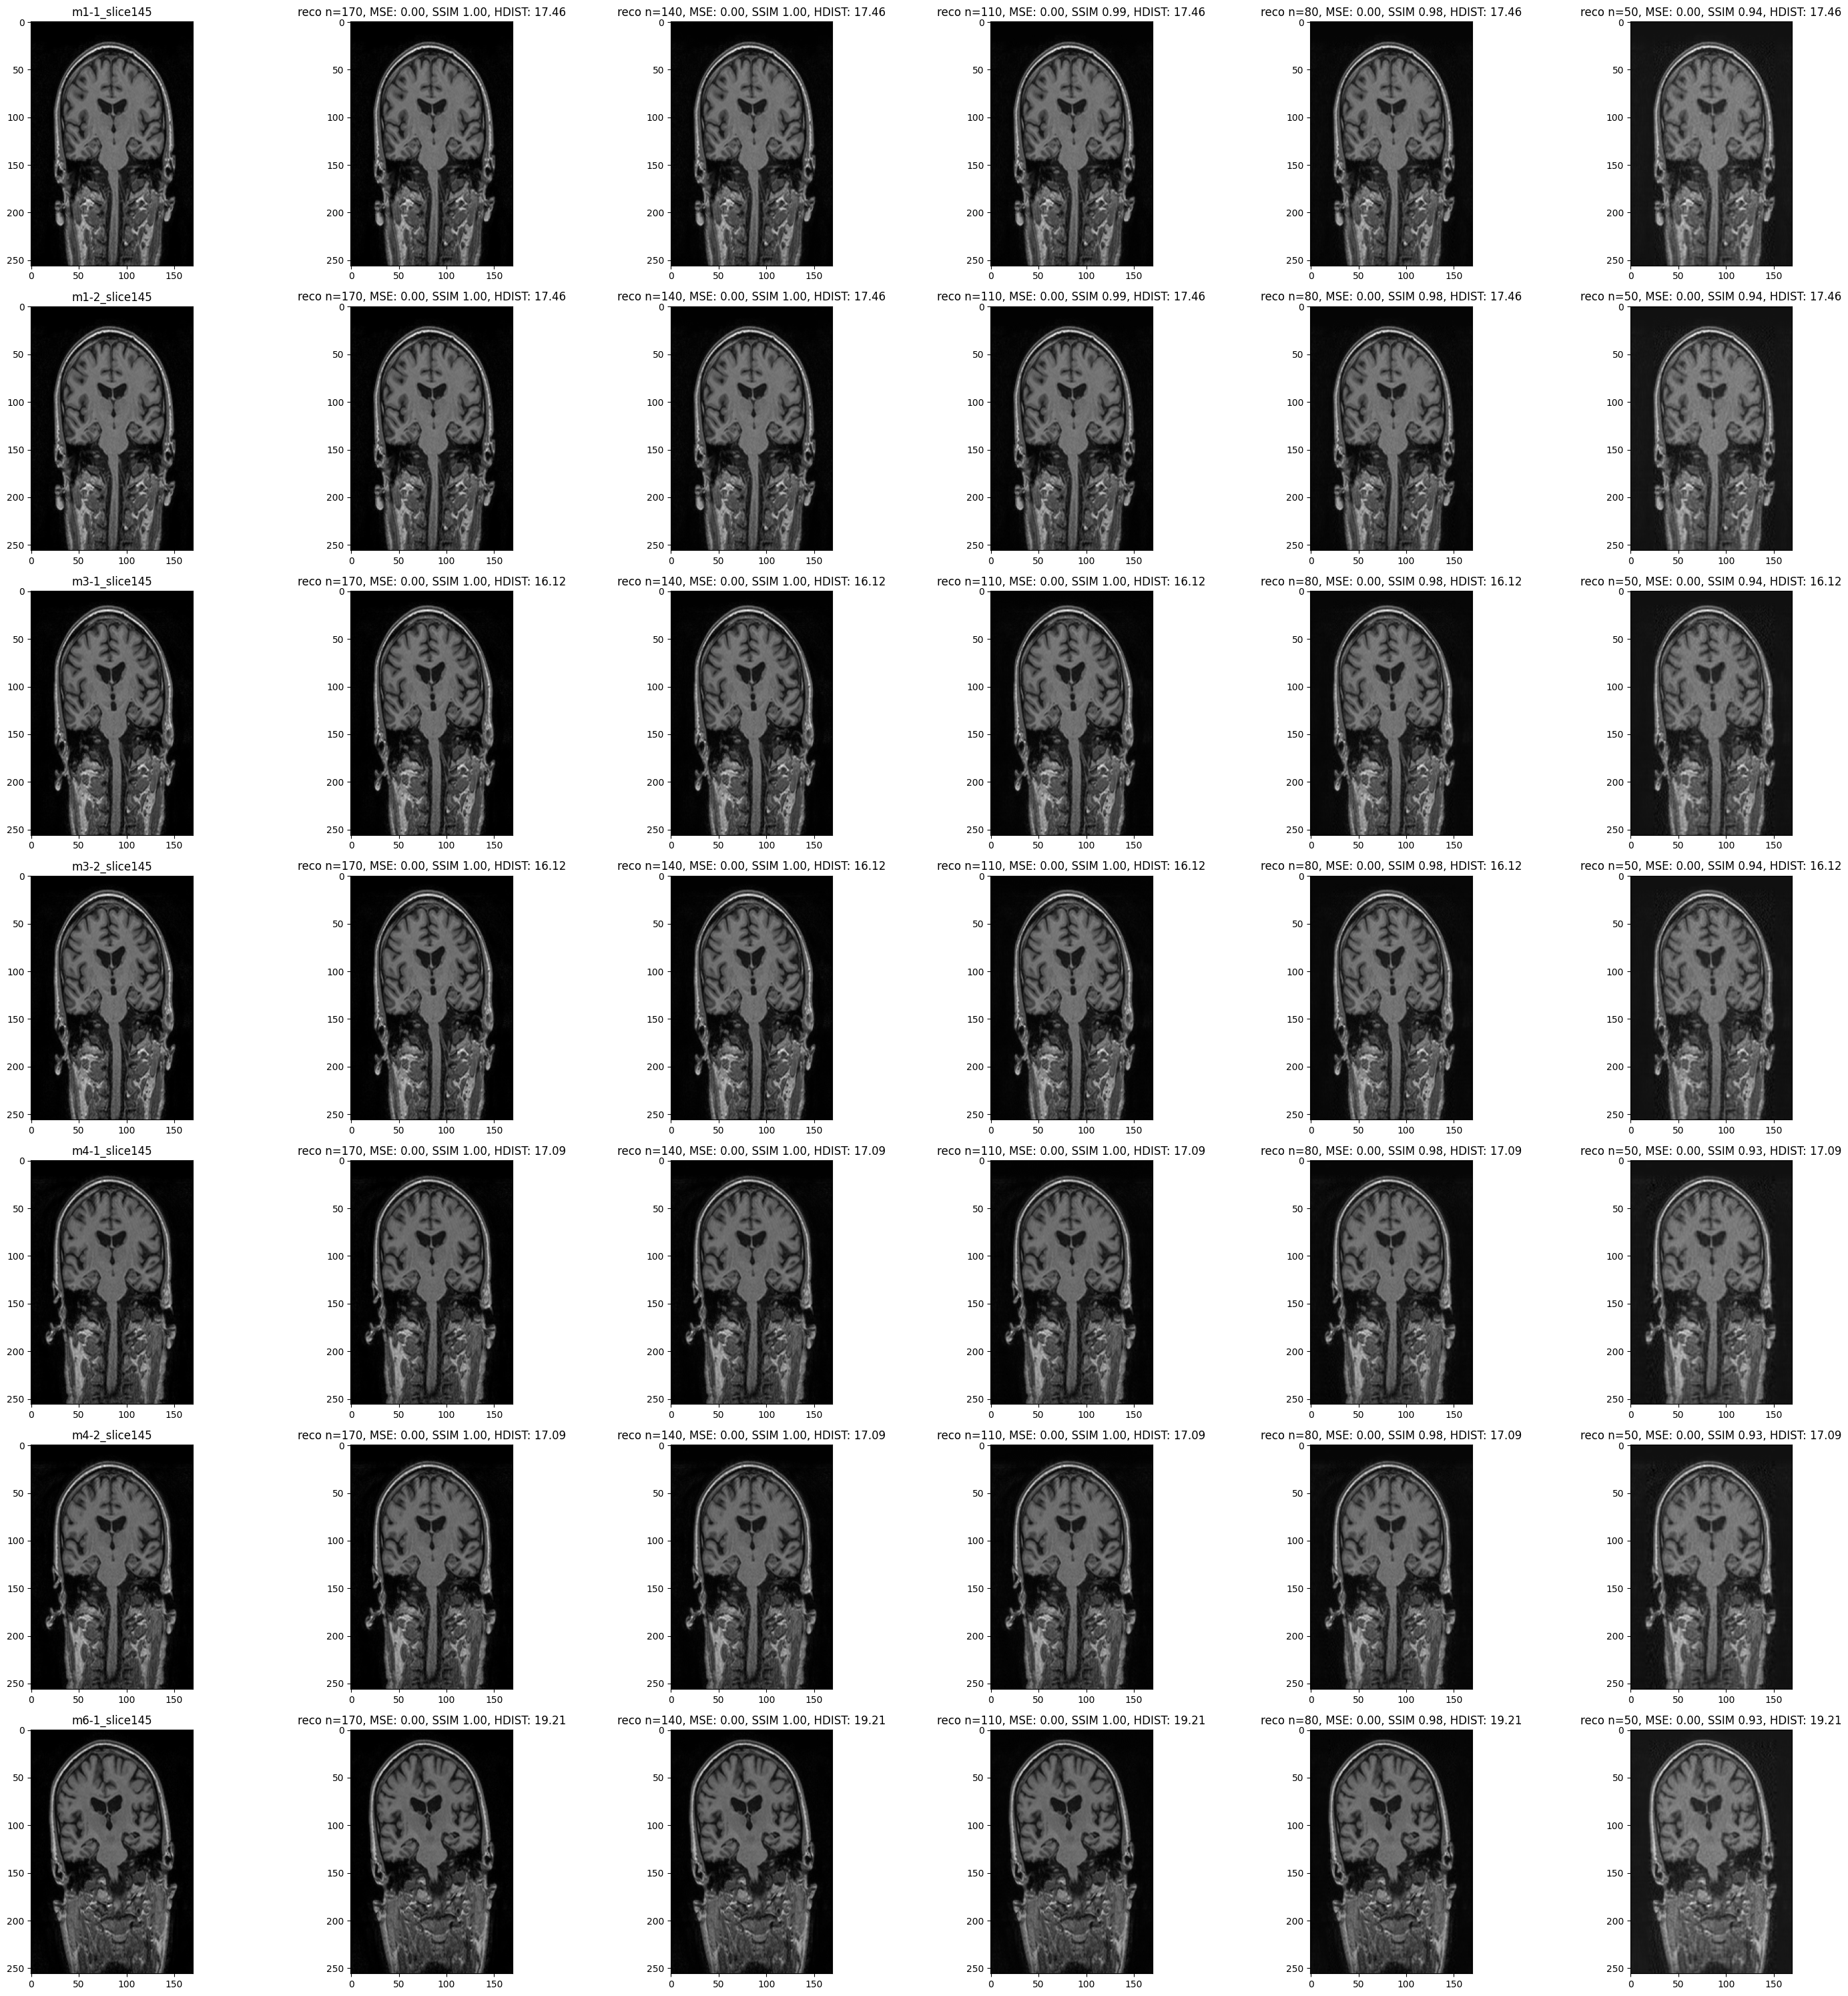

In [22]:
import jax.numpy as jnp
from jax import jit, lax
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
import imageio.v3 as imageio
import os
import glob


# Define the JAX SVD reconstruction function
def reconstruct_svd_jax(u, s, vt, k):
    @jit
    def _reconstruct_svd_jax(u_slice, s_slice, vt_slice):
        reco = jnp.dot(u_slice, jnp.dot(jnp.diag(s_slice), vt_slice))
        return reco

    u_slice = u[:, :k]
    s_slice = s[:k]
    vt_slice = vt[:k, :]
    return _reconstruct_svd_jax(u_slice, s_slice, vt_slice)


# Calculate metrics for reconstruction quality
def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    ssim_score = metrics.structural_similarity(im, reco, data_range=1)
    hdist = metrics.hausdorff_distance(im, reco)
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"


# Load the images
subfolder = "001"
folders = os.path.join("adni_png", subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Get all the names of the files
names = [f[-17:-4] for f in files]

print(images.shape)

# Plot the images and their reconstructions
fig, axs = plt.subplots(images.shape[0], 6, figsize=(30, 30))

for a in range(images.shape[0]):
    im = images[a]
    im = (im - im.min()) / (im.max() - im.min())  # normalize image
    u, s, vt = np.linalg.svd(im, full_matrices=False)

    u_jax, s_jax, vt_jax = jnp.array(u), jnp.array(s), jnp.array(vt)

    axs[a, 0].imshow(im, cmap="gray")
    axs[a, 0].set_title(names[a])

    if a == 0:
        print("original size: ", im.shape[0] * im.shape[1])

    for idx, n in enumerate(range(s.shape[0], 20, -30)):
        reco = reconstruct_svd_jax(u_jax, s_jax, vt_jax, n)
        reco_np = np.array(reco)  # convert back to numpy for visualization
        if a == 0:
            print(
                "decomposed to n = ",
                n,
                ", size: ",
                u.shape[0] * n + n + vt.shape[0] * n,
            )

        axs[a, idx + 1].imshow(reco_np, cmap="gray")
        axs[a, idx + 1].set_title(
            "reco n=" + str(n) + ", " + calculate_metrics(im, reco_np)
        )
plt.tight_layout()
plt.show()

Number of Components: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]


Model  Number of Components  Time Taken
0             reconstruct_svd_jax                    10    0.104005
1        reconstruct_svd_jax_loop                    10    0.053239
2    reconstruct_svd_jax_parallel                    10    0.633044
3             reconstruct_svd_jax                    11    0.099010
4        reconstruct_svd_jax_loop                    11    0.000111
..                            ...                   ...         ...
268      reconstruct_svd_jax_loop                    99    0.000493
269  reconstruct_svd_jax_parallel                    99    0.167354
270           reconstruct_svd_jax                   100    0.094929
271      reconstruct_svd_jax_loop                   100    0.000453
272  reconstruct_svd_jax_parallel                   100    0.159789

[273 rows x 3 columns]

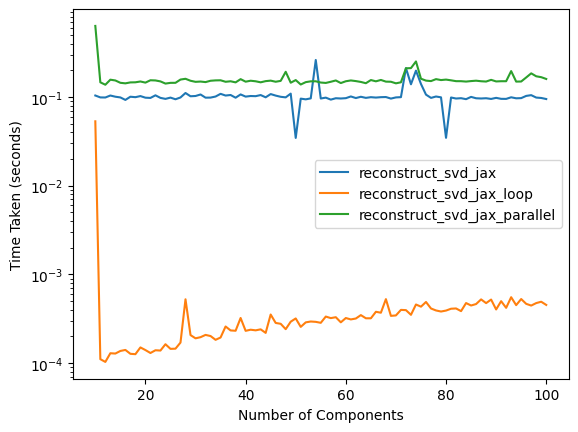

In [23]:
import jax.numpy as jnp
from jax import jit, lax, vmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import timeit
import numba
from numba import prange
import imageio.v3 as imageio
import os
import glob


# Define JAX SVD reconstruction function
def reconstruct_svd_jax(u, s, vt, k):
    @jit
    def _reconstruct_svd_jax(u_slice, s_slice, vt_slice):
        reco = jnp.dot(u_slice, jnp.dot(jnp.diag(s_slice), vt_slice))
        return reco

    u_slice = u[:, :k]
    s_slice = s[:k]
    vt_slice = vt[:k, :]
    return _reconstruct_svd_jax(u_slice, s_slice, vt_slice)


# Define JAX SVD reconstruction function with loops using lax
@jit
def reconstruct_svd_jax_loop(u, s, vt, k):
    def body_fun(i, val):
        u, s, vt, reco = val
        u_slice = lax.dynamic_slice(u, (0, i), (u.shape[0], 1))
        vt_slice = lax.dynamic_slice(vt, (i, 0), (1, vt.shape[1]))
        reco = reco + s[i] * jnp.dot(u_slice, vt_slice)
        return (u, s, vt, reco)

    reco = jnp.zeros((u.shape[0], vt.shape[1]))
    val = (u, s, vt, reco)
    val = lax.fori_loop(0, k, body_fun, val)
    return val[-1]


# Define parallelized JAX SVD reconstruction function using vmap
def reconstruct_svd_jax_parallel(u, s, vt, k):
    def single_reconstruction(u, s, vt):
        u_slice = u[:, :k]
        s_slice = s[:k]
        vt_slice = vt[:k, :]
        return jnp.dot(u_slice, jnp.dot(jnp.diag(s_slice), vt_slice))

    u_batch = jnp.expand_dims(u, axis=0).repeat(10, axis=0)
    s_batch = jnp.expand_dims(s, axis=0).repeat(10, axis=0)
    vt_batch = jnp.expand_dims(vt, axis=0).repeat(10, axis=0)

    return vmap(single_reconstruction)(u_batch, s_batch, vt_batch)[0]


# Load the images
subfolder = "001"
folders = os.path.join("adni_png", subfolder)

# Get all PNGs from 001 with 145 in the name
files = sorted(glob.glob(f"{folders}/*145.png"))

# Load all images using ImageIO and create a numpy array from them
images = np.array([imageio.imread(f) for f in files])

# Normalize images
images = (images - images.min(axis=(1, 2), keepdims=True)) / (
    images.max(axis=(1, 2), keepdims=True) - images.min(axis=(1, 2), keepdims=True)
)

# Perform SVD on the first image to use its components for benchmarking
im = images[0]
u, s, vt = np.linalg.svd(im, full_matrices=False)
u_jax, s_jax, vt_jax = jnp.array(u), jnp.array(s), jnp.array(vt)


# Perform reconstruction function
def perform_reconstruction(model, u, s, vt, num_components):
    start = timeit.default_timer()
    model(u, s, vt, num_components)
    end = timeit.default_timer()
    return end - start


models = [
    reconstruct_svd_jax,
    reconstruct_svd_jax_loop,
    reconstruct_svd_jax_parallel,
]

model_names = [
    "reconstruct_svd_jax",
    "reconstruct_svd_jax_loop",
    "reconstruct_svd_jax_parallel",
]

# Initialize DataFrame
df_jax = pd.DataFrame(
    columns=["Model", "Number of Components", "Time Taken"], dtype=object
)

for num_components in tqdm(range(10, 101), desc="Number of Components"):
    for model, name in zip(models, model_names):
        time_taken = perform_reconstruction(model, u_jax, s_jax, vt_jax, num_components)
        df_jax.loc[len(df_jax)] = [name, num_components, time_taken]

# Display DataFrame
display(df_jax)

for name, group in df_jax.groupby("Model"):
    plt.plot(group["Number of Components"], group["Time Taken"], label=name)

plt.xlabel("Number of Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()

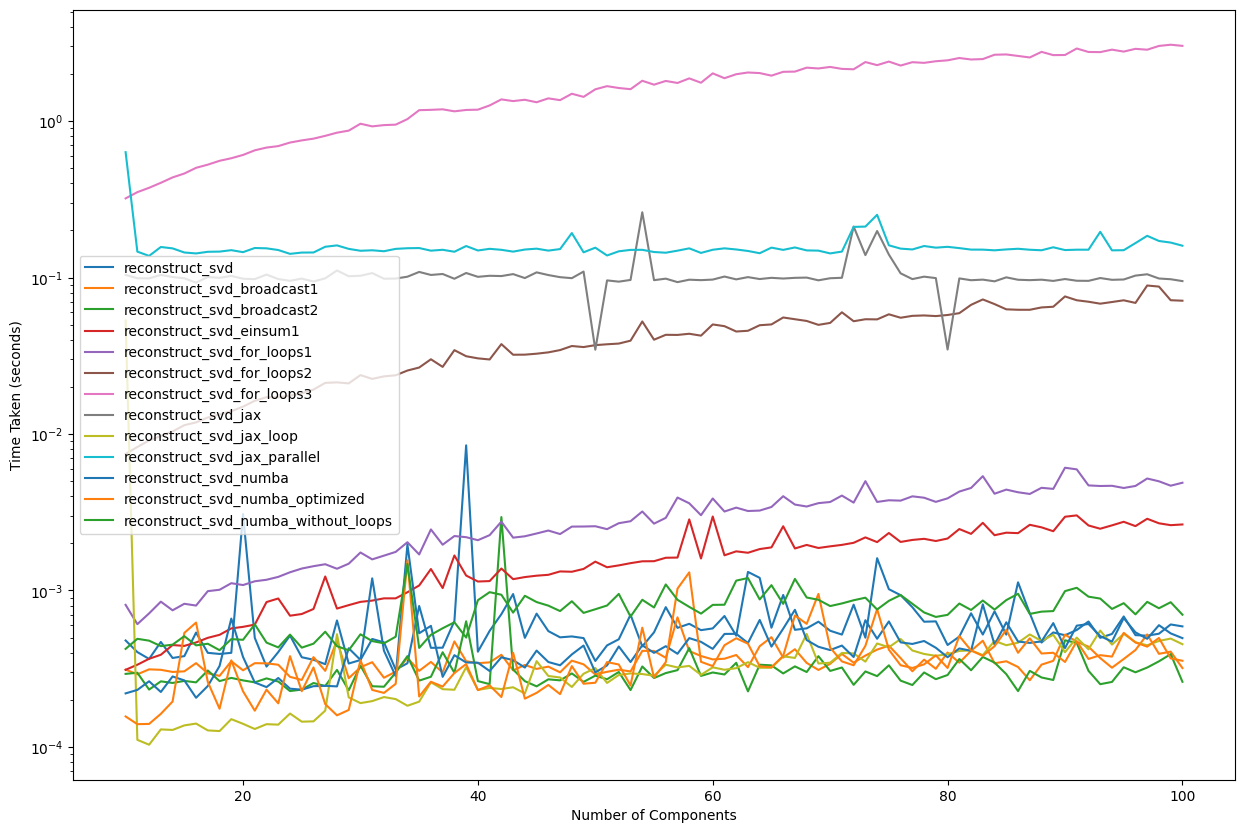

In [24]:
# combine concat df and df_jax
df_combined = pd.concat([df, df_jax])

# Create a new figure with a specific size (width, height)
plt.figure(figsize=(15, 10))

for name, group in df_combined.groupby("Model"):
    plt.plot(group["Number of Components"], group["Time Taken"], label=name)

plt.xlabel("Number of Components")
plt.ylabel("Time Taken (seconds)")
plt.yscale("log")
plt.legend()
plt.show()

In [25]:
# change how many rows are displayed
pd.set_option("display.max_rows", 1000000)
# print df_combined best results for each number of components
df_result = df_combined.loc[
    df_combined.groupby("Number of Components")["Time Taken"].idxmin()
]
# drop duplicates on 'Number of Components'
df_result = df_result.drop_duplicates(subset="Number of Components", keep="first")
# order by number of components
df_result = df_result.sort_values(by="Number of Components")
df_result.head(1000000)

Model  Number of Components  Time Taken
9    reconstruct_svd_numba_optimized                    10    0.000157
4           reconstruct_svd_jax_loop                    11    0.000111
7           reconstruct_svd_jax_loop                    12    0.000103
9                reconstruct_svd_jax                    13    0.103974
13          reconstruct_svd_jax_loop                    14    0.000128
16          reconstruct_svd_jax_loop                    15    0.000137
19          reconstruct_svd_jax_loop                    16    0.000141
22          reconstruct_svd_jax_loop                    17    0.000128
25          reconstruct_svd_jax_loop                    18    0.000126
28          reconstruct_svd_jax_loop                    19    0.000150
31          reconstruct_svd_jax_loop                    20    0.000141
34          reconstruct_svd_jax_loop                    21    0.000130
37          reconstruct_svd_jax_loop                    22    0.000140
40          reconstruct_svd_jax_loop                    23    0.000139
43          reconstruct_svd_jax_loop                    24    0.000163
46          reconstruct_svd_jax_loop                    25    0.000145
49          reconstruct_svd_jax_loop                    26    0.000146
52          reconstruct_svd_jax_loop                    27    0.000171
189  reconstruct_svd_numba_optimized                    28    0.000159
199  reconstruct_svd_numba_optimized                    29    0.000172
61          reconstruct_svd_jax_loop                    30    0.000191
64          reconstruct_svd_jax_loop                    31    0.000196
67          reconstruct_svd_jax_loop                    32    0.000208
70          reconstruct_svd_jax_loop                    33    0.000202
73          reconstruct_svd_jax_loop                    34    0.000183
76          reconstruct_svd_jax_loop                    35    0.000195
79          reconstruct_svd_jax_loop                    36    0.000259
82          reconstruct_svd_jax_loop                    37    0.000234
85          reconstruct_svd_jax_loop                    38    0.000232
88          reconstruct_svd_jax_loop                    39    0.000323
309  reconstruct_svd_numba_optimized                    40    0.000231
94          reconstruct_svd_jax_loop                    41    0.000238
329  reconstruct_svd_numba_optimized                    42    0.000208
100         reconstruct_svd_jax_loop                    43    0.000241
349  reconstruct_svd_numba_optimized                    44    0.000204
359  reconstruct_svd_numba_optimized                    45    0.000222
369  reconstruct_svd_numba_optimized                    46    0.000249
379  reconstruct_svd_numba_optimized                    47    0.000218
115         reconstruct_svd_jax_loop                    48    0.000242
399  reconstruct_svd_numba_optimized                    49    0.000253
409  reconstruct_svd_numba_optimized                    50    0.000257
124         reconstruct_svd_jax_loop                    51    0.000256
127         reconstruct_svd_jax_loop                    52    0.000288
436       reconstruct_svd_broadcast2                    53    0.000231
133         reconstruct_svd_jax_loop                    54    0.000292
456       reconstruct_svd_broadcast2                    55    0.000276
466       reconstruct_svd_broadcast2                    56    0.000297
476       reconstruct_svd_broadcast2                    57    0.000310
145         reconstruct_svd_jax_loop                    58    0.000330
496       reconstruct_svd_broadcast2                    59    0.000284
506       reconstruct_svd_broadcast2                    60    0.000299
516       reconstruct_svd_broadcast2                    61    0.000290
157         reconstruct_svd_jax_loop                    62    0.000319
536       reconstruct_svd_broadcast2                    63    0.000227
163         reconstruct_svd_jax_loop                    64    0.000321
166         reconstruct_svd_jax_loop                   